# Neural Network in NumPy: No TensorFlow and no PyTorch
---

**Reference:** Implementation inspired by [Let’s code a Neural Network in plain NumPy](https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795) by Piotr Skalski.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Neural network architecture

![Neural Network](https://storage.googleapis.com/activation-function/images/jupyter/nn.png)

<b>Figure 1.</b> Layers: {1 − 64 − ReLU − 64 − ReLU − 64 − 1 − sigmoid}. The diagram only shows 32-neuron hidden layers because the diagram with 64 neurons was too unwieldy.

## First things first

Before we start programming, let's stop for a moment and prepare a basic roadmap. Our goal is to create a program capable of creating a densely connected neural network with the specified architecture (number and size of layers and appropriate activation function). An example of such a network is presented in Figure 1. Above all, we must be able to our network and make predictions using it.

Diagram above shows what operations will have to be performed during the training of our neural network. It also shows how many parameters we will have to update and read at different stages of a single iteration. Building the right data structure and skillfully managing its state is the most difficult part of our task.

## Define neural network architecture

Layers: {1 − 64 − ReLU − 64 − ReLU − 64 − 1 − sigmoid}

Unlike in Keras where you only have to specify the input dim on the very first layer, this implementation requires that you specify it for each layer.

In [2]:
neural_network = [
    {"input_dim": 1, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 1, "activation": "sigmoid"},
]

## Initiation of parameter values for each layer

In [3]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)

    number_of_layers = len(nn_architecture)
    params_values = {}
    
    # For each neural network layer
    for idx, layer in enumerate(nn_architecture):
        # Number network layers from 1.
        layer_idx = idx + 1
        
        # Extract the number of units in layers.
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # Initiate the values of the W matrix and vector b for subsequent
        # layers. Initialize the weights using a Gaussian distribution.
        params_values['W' + str(layer_idx)] = np.random.normal(0, 1, size=(layer_output_size, layer_input_size)) * (np.sqrt(np.divide(2,layer_input_size)))
        params_values['b' + str(layer_idx)] = np.zeros((layer_output_size, 1))
        
    return params_values

## Activation functions

![ReLU](https://storage.googleapis.com/activation-function/images/jupyter/relu.jpg)
![Sigmoid](https://storage.googleapis.com/activation-function/images/jupyter/sigmoid.png)

<b>Figure 4.</b> Activation functions used in the algorithm.

In [4]:
def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

## Single layer forward propagation step

For each layer in the neural network, take the weight matrix of that layer and dot it with the activation matrix of the previous layer then add the bias for that layer.

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$

Now that that calculated value Z and pass it through an activation function.

$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [5]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # Calculate the input value for the activation function.
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # Activation function
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # Return the calculated activation A and the intermediate Z matrix.
    return activation_func(Z_curr), Z_curr

## Full forward propagation

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    # Create temporary memory to store the information needed for a backward step.
    memory = {}
    # X vector is the activation for layer 0.
    A_curr = X
    
    # For each network layer
    for idx, layer in enumerate(nn_architecture):
        # Number network layers from 1.
        layer_idx = idx + 1
        # Transfer the activation from the previous iteration.
        A_prev = A_curr
        
        # Extract the activation function for the current layer.
        activ_function_curr = layer["activation"]
        # Extract W for the current layer.
        W_curr = params_values["W" + str(layer_idx)]
        # Extract b for the current layer.
        b_curr = params_values["b" + str(layer_idx)]
        # Calculate the activation for the current layer.
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # Save calculated values in the memory cache.
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # Return prediction vector and a dictionary containing intermediate values.
    return A_curr, memory

## Calculate cost using MSE

Mean Squared Error

![Cost Function](https://storage.googleapis.com/activation-function/images/jupyter/mse.png)

We will used MSE for this linear regression problem.

In [7]:
def mse(Y_hat, Y):
    j = np.mean(np.square(np.subtract(Y, Y_hat)))
    return j

## Single layer backward propagation step

Use backward propagation to calculate the gradient, and use gradient descent to minimize the calculated gradient.

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$



In [8]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # Number of examples
    m = A_prev.shape[1]
    
    # Activation function
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # Calculate the activation function derivative.
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # Derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # Derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # Derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

## Full backward propagation

$$\frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$

In [9]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # Number of examples
    m = Y.shape[1]
    # Ensure the same shape of the prediction vector and labels vector.
    Y = Y.reshape(Y_hat.shape)
    
    # Initiate gradient descent algorithm.
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # Number network layers from 1.
        layer_idx_curr = layer_idx_prev + 1
        # Extract the activation function for the current layer.
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Update weights and biases

Update the weights and bias of each layer. The learning rate is used to dictate the amount of update to perform.

In [10]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    # For each network layer
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

## Training

In [11]:
def model_fit(X, Y, nn_architecture, epochs, learning_rate, verbose=True, callback=None):
    # Initialize the neural network.
    params_values = init_layers(nn_architecture, 2)
    
    # Declare lists for storing the history of metrics
    # calculated during the learning process.
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        # Forward propagation
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        
        # Calculate metrics.
        cost = mse(Y_hat, Y)
        cost_history.append(cost)
        
        # Backpropagation
        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        
        # Update parameters.
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(verbose):
            print("Epoch: {} - MSE: {:.5f}".format(i, cost))
        if(callback is not None):
            callback(i, params_values)
            
    return params_values

## Start the action

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Create dataset

In [13]:
mu = 1     # float(input('Mean:'))
sigma = 2  # float(input('Std Dev:'))

samples = np.random.normal(mu, sigma, 1000000)
limited_sampling = []

while len(limited_sampling) < 1000000:
    # Limit samples between −2σ and +2σ.
    sample = np.random.choice(samples)
    if sample >= (mu - 2 * sigma) and sample <= (mu + 2 * sigma):
        limited_sampling.append(sample)

dataset = np.array(limited_sampling)

# Compute the histogram of the Gaussian dataset.
hist, bin_edges = np.histogram(dataset, bins=1000, density=True)

# Return the indices of the bins to which each value in input array belongs.
indices = np.digitize(dataset, bin_edges, right=True) - 1

X = dataset[:1000]
y = hist[indices][:1000]

# Split 90% for training and 10% for testing.
x_train, x_test = np.split(X, [900])
y_train, y_test = np.split(y, [900])

# Reshaped the input data to properly fit the neural network.
X_train = x_train.reshape(-1, 1)
X_test  = x_test.reshape(-1, 1)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')

X_train.shape: (900, 1)
y_train.shape: (900,)


### Train the network and make predictions

Epoch: 0 - MSE: 0.37959
Epoch: 1 - MSE: 0.02187
Epoch: 2 - MSE: 0.02088
Epoch: 3 - MSE: 0.01949
Epoch: 4 - MSE: 0.01766
Epoch: 5 - MSE: 0.01558
Epoch: 6 - MSE: 0.01400
Epoch: 7 - MSE: 0.01387
Epoch: 8 - MSE: 0.01434
Epoch: 9 - MSE: 0.01436
Epoch: 10 - MSE: 0.01420
Epoch: 11 - MSE: 0.01399
Epoch: 12 - MSE: 0.01380
Epoch: 13 - MSE: 0.01361
Epoch: 14 - MSE: 0.01341
Epoch: 15 - MSE: 0.01322
Epoch: 16 - MSE: 0.01303
Epoch: 17 - MSE: 0.01284
Epoch: 18 - MSE: 0.01265
Epoch: 19 - MSE: 0.01246


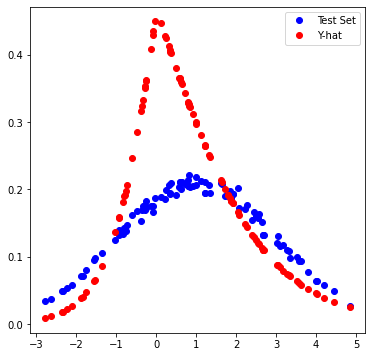

In [14]:
params_values = model_fit(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), neural_network, 20, 0.1,  verbose=True)

Y_hat_test, _ = full_forward_propagation(np.transpose(X_test), params_values, neural_network)

plt.figure(figsize=(6, 6))
plt.plot(X_test, y_test, 'o', color='blue', label='Test Set')
plt.plot(X_test, np.transpose(np.squeeze(Y_hat_test)), 'o', color='red', label='Y-hat')
plt.legend(loc='upper right')
plt.show()

At only 20 epochs, the predictions do not look impressive. I notice that at around 500 epochs, the predictions start to look good. Let's run it again for 500 epochs.

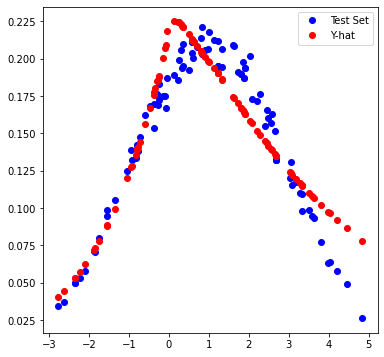

In [15]:
params_values = model_fit(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), neural_network, 500, 0.1,  verbose=False)

Y_hat_test, _ = full_forward_propagation(np.transpose(X_test), params_values, neural_network)

plt.figure(figsize=(6, 6))
plt.plot(X_test, y_test, 'o', color='blue', label='Test Set')
plt.plot(X_test, np.transpose(np.squeeze(Y_hat_test)), 'o', color='red', label='Y-hat')
plt.legend(loc='upper right')
plt.show()

Big difference in generalization power compared to the one ran on only 20 epochs.

### Trying the same neural network in Keras just for comparison

Epoch 1/20
29/29 [==============================] - 0s 1ms/step - loss: 0.0377 - mae: 0.1633
Epoch 2/20
29/29 [==============================] - 0s 1ms/step - loss: 0.0116 - mae: 0.0836
Epoch 3/20
29/29 [==============================] - 0s 987us/step - loss: 0.0059 - mae: 0.0654
Epoch 4/20
29/29 [==============================] - 0s 1ms/step - loss: 0.0037 - mae: 0.0537
Epoch 5/20
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - mae: 0.0451
Epoch 6/20
29/29 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0381
Epoch 7/20
29/29 [==============================] - 0s 979us/step - loss: 0.0014 - mae: 0.0327
Epoch 8/20
29/29 [==============================] - 0s 1ms/step - loss: 0.0011 - mae: 0.0284
Epoch 9/20
29/29 [==============================] - 0s 1ms/step - loss: 8.4823e-04 - mae: 0.0251
Epoch 10/20
29/29 [==============================] - 0s 1ms/step - loss: 6.9499e-04 - mae: 0.0224
Epoch 11/20
29/29 [==============================] - 0s 1

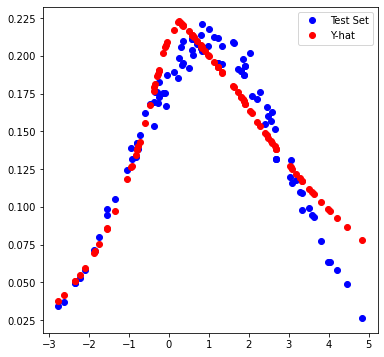

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, input_dim=1,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer=SGD(learning_rate=0.1), metrics=['mae'])

history = model.fit(X_train, y_train, epochs=20, verbose=1)

Y_hat_test_keras = model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.plot(X_test, y_test, 'o', color='blue', label='Test Set')
plt.plot(X_test, np.transpose(np.squeeze(Y_hat_test_keras)), 'o', color='red', label='Y-hat')
plt.legend(loc='upper right')
plt.show()

At only 20 epochs, the predictions already look great.

This may mean that my Numpy neural network takes a long time to learn. I'm not happy about this. It shouldn't be this slow to learn. Future improvement includes looking into why the generalization ability of my Numpy neural net could not learn enough to be a decent predictor with 20 epochs.